In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

from numba.core.errors import NumbaWarning, NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [3]:
from scipy.stats import multivariate_normal

@jit
def target_1(z, mean=[1, 3], cov=np.eye(2)):
    assert(len(z) == 2)
    
    return multivariate_normal.pdf(z, mean=mean, cov=cov)

Text(0.5, 1.0, 'Contour plot of the density for a = 10')

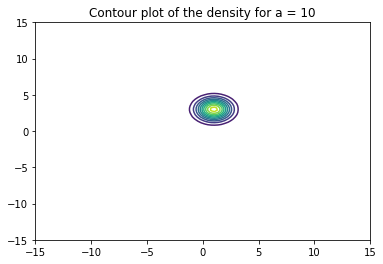

In [4]:
X = np.linspace(-15, 15, 100)
Y = np.linspace(-15, 15, 100)

Z = np.zeros((len(X), len(Y)))


for i in range(len(X)):
    for j in range(len(Y)):
        Z[i, j] = target_1([X[i], Y[j]])

plt.contour(X, Y, Z.T, levels=10)
plt.title("Contour plot of the density for a = 10")

In [5]:
@jit
def sampler_full(z0, pi, drift, sigma, maxIter, batch_size=50):
    d = len(z0)
    z = z0
    
    samples = np.zeros((maxIter, d))
    count_accept = 0
    mean_acceptance_rate = []
    
    for i in range(maxIter):
        z_proposal = z + sigma**2 / 2  * drift(z) + np.random.multivariate_normal(mean=[0 for _ in range(d)], cov=sigma**2 * np.eye(d))
        
        log_alpha = min(0, np.log(pi(z_proposal) + 1e-8) - np.log(pi(z) + 1e-8))
        
        if np.log(np.random.rand()) < log_alpha:
            z = z_proposal
            count_accept += 1
        
        if i % batch_size == 0:
            mean_acceptance_rate.append(count_accept / batch_size)
            count_accept = 0

        samples[i, :] = z
    
    return samples, mean_acceptance_rate        

In [6]:
import pandas as pd
def cross_corr(x, y, max_lag=None):
    """
    Cross-correlation function of 2 time series
    """
    if max_lag is None:
        max_lag = len(x)
    
    sx = pd.Series(x)
    sy = pd.Series(y)
    res = np.zeros(max_lag)
    for lag in range(1, max_lag):
        res[lag] = sx.corr(sy.shift(lag))
    res[0] = 1
    return res

def plot_graphs(Z, MR):
    """
    function to plot 4 graphs:
        * sample
        * mean acceptance ratio
        * cross-correlation of the last 1000 samples
        * cross-correlation of all the samples
    """
    nb_iter = Z.shape[0]
    burn_in = nb_iter // 2
    
    fig = plt.figure(figsize=(10, 10))   
    
    ax0 = fig.add_subplot(2, 2, 1)    
    X = samples[burn_in:, 0]
    Y = samples[burn_in:, 1]    
    grid_x = np.linspace(-5, 5, 1000)
    grid_y = np.linspace(-5, 5, 1000)
    ax0.plot(X, Y, "x")
    ax0.set_xlabel("Sample with MH")
    
    ax1 = fig.add_subplot(2, 2, 2)
    ax1.plot(np.arange(len(MR)), MR, "-x")
    ax1.set_xlabel("Mean Acceptance Ratio")
    
    
    
    ax3 = fig.add_subplot(2, 2, 3)
    X = samples[-1000:, 0]
    Y = samples[-1000:, 1]
    c_xx = cross_corr(X, X, max_lag=50)
    c_yy = cross_corr(Y, Y, max_lag=50)
    c_xy = cross_corr(X, Y, max_lag=50)

    ax3.plot(np.arange(c_xx.shape[0]), c_xx, label="Corr(x, x)")
    ax3.plot(np.arange(c_yy.shape[0]), c_yy, label="Corr(x, y)")
    ax3.plot(np.arange(c_xy.shape[0]), c_xy, label="Corr(y, y)")
    ax3.set_xlabel("Time shift")
    ax3.set_ylabel("Correlation (1000 last samples)")
    ax3.legend()
    
    ax4 = fig.add_subplot(2, 2, 4)
    X = samples[:, 0]
    Y = samples[:, 1]
    c_xx = cross_corr(X, X, max_lag=50)
    c_yy = cross_corr(Y, Y, max_lag=50)
    c_xy = cross_corr(X, Y, max_lag=50)

    ax4.plot(np.arange(c_xx.shape[0]), c_xx, label="Corr(x, x)")
    ax4.plot(np.arange(c_yy.shape[0]), c_yy, label="Corr(x, y)")
    ax4.plot(np.arange(c_xy.shape[0]), c_xy, label="Corr(y, y)")
    ax4.set_xlabel("Time shift")
    ax4.set_ylabel("Correlation all")
    ax4.legend()
    
    plt.show()

In [7]:
@jit
def no_drift(z):
    d = len(z)
    return np.zeros((d))

def drift(z, mean=np.array([2, 3]), cov=np.eye(2), delta=1000):
    assert(len(z) == 2)
    x, y = z
    
    gradient = - np.linalg.inv(cov) @ (z - mean)
    norm_grad = np.linalg.norm(gradient)    
    
    
    return delta / max(delta, norm_grad) * gradient
        

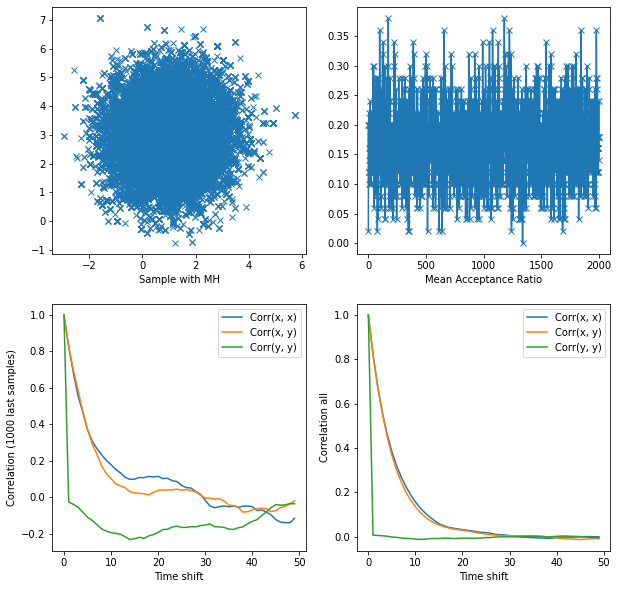

Estimation of the mean (x-axis) 1.0130173550222006
Estimation of the mean (y-axis) 3.014625418652457
Estimation of the covariance matrix [[1.03101216 0.0200244 ]
 [0.0200244  0.9869997 ]]


In [32]:
# fine tune sigma to get acceptance ratio around 3
sample_size = 100000
samples, mean_rate = sampler_full([0, 0], target_1, no_drift, 3, sample_size, batch_size=50)
plot_graphs(samples, mean_rate)


burn_in = sample_size//2
X = samples[burn_in:, 0]
Y = samples[burn_in:, 1]

print("Estimation of the mean (x-axis)", np.mean(X))
print("Estimation of the mean (y-axis)", np.mean(Y))
print("Estimation of the covariance matrix", np.cov(X, Y))

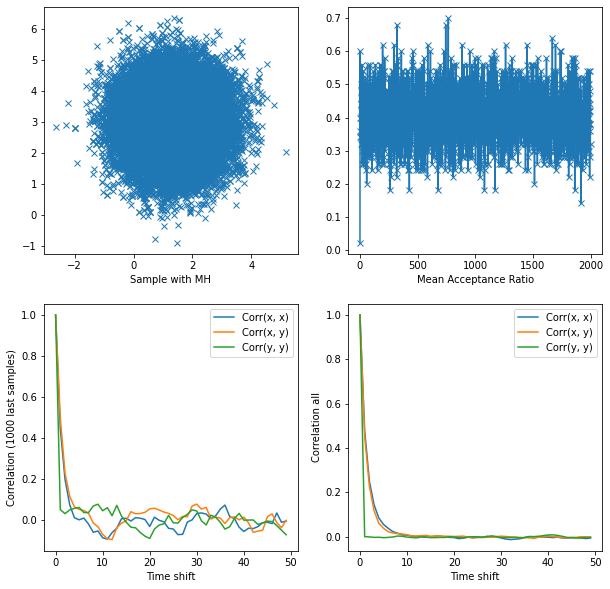

Estimation of the mean (x-axis) 1.3087572460659107
Estimation of the mean (y-axis) 3.005774181257317
Estimation of the covariance matrix [[ 7.00253268e-01 -1.27526094e-04]
 [-1.27526094e-04  6.97517019e-01]]


In [33]:
# fine tune to get acceptance ratio around .5
sample_size = 100000
samples, mean_rate = sampler_full([0, 0], target_1, drift, 1.5, sample_size, batch_size=50)
plot_graphs(samples, mean_rate)

burn_in = sample_size//2
X = samples[burn_in:, 0]
Y = samples[burn_in:, 1]

print("Estimation of the mean (x-axis)", np.mean(X))
print("Estimation of the mean (y-axis)", np.mean(Y))
print("Estimation of the covariance matrix", np.cov(X, Y))

In [76]:
# global variables
eps1 = 1e-7
eps2 = 1e-6
A1 = 1e7


def p1(sigma):
    if sigma < eps1:
        return eps1
    elif sigma > A1:
        return A1
    return sigma


def p2(Sigma):
    frob_norm = np.linalg.norm(Sigma)
    if frob_norm <= A1:
        return Sigma
    return A1/frob_norm * Sigma


def p3(x):
    x_norm = np.linalg.norm(x)
    if x_norm <= A1:
        return x
    return A1 / x_norm * x


def sampler_full_adaptive(z0, pi, drift, maxIter, tau_bar=.5, batch_size=50):
    # initialisation
    d = len(z0)
    z = z0
    
    mu = [0 for _ in range(d)]
    Lambda = np.eye(d)
    sigma = 1
    
    samples = np.zeros((maxIter, d))
    count_accept = 0
    mean_acceptance_rate = []
    
    for i in range(maxIter):
        # set Delta n
        Delta = Lambda + eps2 * np.eye(d)
        z_proposal = z + sigma**2 / 2  * Delta @ drift(z) + np.random.multivariate_normal(mean=mu, cov=Delta)
        
        log_alpha = min(0, np.log(pi(z_proposal) + 1e-8) - np.log(pi(z) + 1e-8))
        
        if np.log(np.random.rand()) < log_alpha:
            z = z_proposal
            count_accept += 1
        
        if i % batch_size == 0:
            mean_acceptance_rate.append(count_accept / batch_size)
            count_accept = 0

        if i >= maxIter // 10:
            sigma = p1(sigma + 10/i * (np.exp(log_alpha) - tau_bar))
            if i % 5000 == 0:         
                mu = p3(mu + 10/i * (z - mu))
                Lambda = p2(Lambda + 10/i * ((z - mu) @ (z - mu).T - Lambda))
        
        
        samples[i, :] = z
    print(sigma, mu, Lambda)
    return samples, mean_acceptance_rate        

1.6212915349873485 [0.00594467 0.01540896] [[1.05286759 0.05795129]
 [0.05795129 1.05286759]]


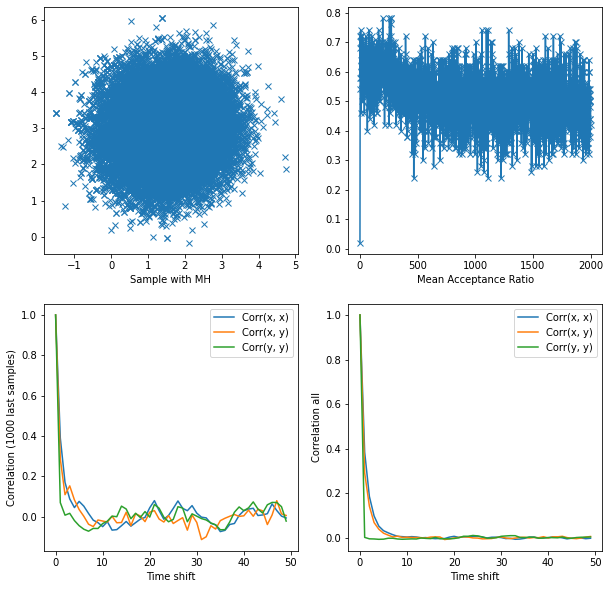

Estimation of the mean (x-axis) 1.4405363641594293
Estimation of the mean (y-axis) 2.972496126288267
Estimation of the covariance matrix [[0.55682606 0.0356531 ]
 [0.0356531  0.56000467]]


In [77]:
# fine tune to get acceptance ratio around .5
sample_size = 100000
samples, mean_rate = sampler_full_adaptive([0, 0], target_1, drift, maxIter=sample_size, tau_bar=.5, batch_size=50)
plot_graphs(samples, mean_rate)

burn_in = sample_size//2
X = samples[burn_in:, 0]
Y = samples[burn_in:, 1]

print("Estimation of the mean (x-axis)", np.mean(X))
print("Estimation of the mean (y-axis)", np.mean(Y))
print("Estimation of the covariance matrix", np.cov(X, Y))

8.965024387983952 [0.00573701 0.01767931] [[1.07013718 0.07522088]
 [0.07522088 1.07013718]]


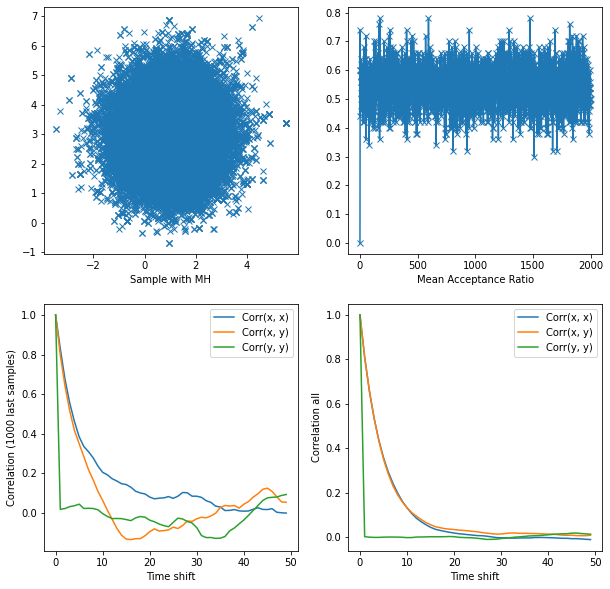

Estimation of the mean (x-axis) 1.0026339274177103
Estimation of the mean (y-axis) 3.043496303768403
Estimation of the covariance matrix [[1.01074684 0.01092179]
 [0.01092179 1.0031729 ]]


In [78]:
# fine tune to get acceptance ratio around .2
sample_size = 100000
samples, mean_rate = sampler_full_adaptive([0, 0], target_1, no_drift, maxIter=sample_size, tau_bar=.2, batch_size=50)
plot_graphs(samples, mean_rate)

burn_in = sample_size//2
X = samples[burn_in:, 0]
Y = samples[burn_in:, 1]

print("Estimation of the mean (x-axis)", np.mean(X))
print("Estimation of the mean (y-axis)", np.mean(Y))
print("Estimation of the covariance matrix", np.cov(X, Y))

**Comment**

Regarder pouquoi cela marche bien dans le cas de MALA adaptatif mais pas dans le cas de la Symmetric Random Walk.